# Decision tree, K-nearest neighbor, and the Bias-Variance Trade-Off
**Acknowledgment**: Noah Smith, Chris Ketelsen, Chenhao Tan 

**Name**: 


### Toshal Ghimire
### Student ID: 103075763

In [2]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import pandas as pd
import copy

### [30 points] Problem 1 - Decision tree
***

Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency. 
The dataset looks like the following.

| Age   | Salary         | Colorado Residency      | College degree| 
|:------:|:------------:| :-----------:|---:|
| 24 | 40,000 | Yes | Yes |
| 53 | 52,000 | No | No |
| 23 | 25,000 | Yes | No |
| 25 | 77,000 | Yes | Yes |
| 32 | 48,000 | No | Yes |
| 52 | 110,000 | Yes | Yes |
| 22 | 38,000 | Yes | Yes |
| 43 | 44,000 | Yes | No |
| 52 | 27,000 | No | No |
| 48 | 65,000 | Yes | Yes |


**Part 1 [5 points]**: Convert the above table to data. Two variables should be created:
        
1. $x$ is a $10*3$ matrix that contains the data from columns 0, 1, and 2. Colorado residency is represented by 1 (yes) and 0 (no).
2. $y$ contains the labels (college degree), 1 (yes) and 0 (no).

In [4]:
Age = [24,53,23,25,32,52,22,43,52,48] 
Salary = [40000,52000,25000,77000,48000,110000,38000,44000,27000,65000]
ColoradoResidency = [1,0,1,1,0,1,1,1,0,1]

CollegeDegree = [1,0,0,1,1,1,1,0,0,1]

x = [Age,Salary,ColoradoResidency]
y = CollegeDegree

data = pd.DataFrame({'Age':x[0],'Salary':x[1],'Colorado Residency':x[2],'College Degree':y}) 
data


,Age,Salary,Colorado Residency,College Degree
0,24,40000,1,1
1,53,52000,0,0
2,23,25000,1,0
3,25,77000,1,1
4,32,48000,0,1
5,52,110000,1,1
6,22,38000,1,1
7,43,44000,1,0
8,52,27000,0,0
9,48,65000,1,1


**Part 2 [16 points]:** Criteria for choosing a feature to split.

**[2 points]** We start with no splitting. Assuming that our algorithm is deterministic, what is the smallest number of mistakes we can make if we do not use any of the features and what is the algorithm? (**Write your answer in the Markdown cell below.**)

** If we dont use any of the features the smallest number of mistakes we can make is 0 if everything is predicted correctly


**[5 points]** We start by considering the variable *Colorado residency*. The first criteria is based on the numbeer of mistakes. We need to build a confusion matrix between Colorado residency and college degree.

How many mistakes will we make if we split based on Colorado residency? (**Answer below by finishing the code.**)

|||Colorado Residency | Not Colorado Residency|
|:------:||:------:||:------:|
|College Degree||5|1|
|No College Degree||2|2|



we would make 3 mistakes based on this variable

In [5]:
CO_RES = 2
def get_error_in_leaf(y, ids):
    """
    Returns the errors in a leaf node of a decision tree.
    This function can be used to answer the previous question automatically.
    
    :@param y: all labels
    :@param ids: the subset of indexes in the leaf node
    """
    errorCount = 0
    
    for i in ids:
        if(y[i] != x[CO_RES][i]):
            errorCount +=1
            
    return errorCount
    

def error_criteria(y, root, left_child, right_child):
    """
    Returns the number of errors if we split the root into the left child and the right child.
    
    
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    totalError = get_error_in_leaf(y,root)
    leftError = get_error_in_leaf(y,left_child)
    rightError = get_error_in_leaf(y,right_child)
    
    print("Left Error: " + str(leftError))
    print("Right Error: " + str(rightError))
    print("Total Error: " + str(totalError))
    
    # YOUR CODE HERE
    return (leftError + rightError)

def value_split_binary_feature(x, y, fid, root, criteria_func):
    left_child = [i for i in root if x[fid][i] == 0]  
    right_child = [i for i in root if x[fid][i] == 1]
    return criteria_func(y, root, left_child, right_child)

# Colorado residency should correpsond to the third column in your data x
fid = 2
root = list(range(len(y))) # root includes all data points
mistakes = value_split_binary_feature(x, y, fid, root, error_criteria)
mistakes

Left Error: 1
Right Error: 2
Total Error: 3


3

**[3 points]** Alternatively, we can use information gain to split the data. To get you familiar with MathJax, please write the equation necessary to compute information gain if we split data $D$ into $D_1$ and $D_2$. **Write your answer in the Markdown cell below.**

$$ Entropy(X) = -\sum\limits_{c} P_{c} log_{2}(P_c) $$

$$ Gain(T,X) = Entropy(T) - Enthropy(T,X) $$

$$  Gain(X_{parent},i) = Entropy(X_{parent}) - \frac{X_{i,left}}{X_{parent}}~ Entropy(X_{left}) - \frac{X_{i,right}}{X_{parent}}~ Entropy(X_{right}) $$


**[6 points]** Now we write a function for computing information gain. Use log2 for entropy computation.

In [6]:
# **** GRADERS PLEASE IGNORE ****
# TEST CODE CELL 

import math 
def entro(p):
    if(p == 1):
        return 0
    val = -p*math.log(p,2) - (1- p)*math.log(1-p,2)
    
    return val

a = entro(6/10)
b = a - (7/10)*(entro(5/7)) - (3/10)*(entro(2/3)) 
b

0.09127744624168005

In [7]:
def entropy(y, ids):
    """
    Returns the entropy in the labels for the data points in ids.
    
    :@param y: all labels
    :@param ids: the indexes of data points
    """
    if len(ids) == 0: # deal with corner case when there is no data point.
        return 0
    
    val = one = two = 0
    
    # Probality finder
    for i in ids:
        if(y[i] == 1):
            one += 1
        if(y[i] == 0):
            two += 1
            
    p = one/len(ids)
    
    part1 = 0 if p <= 0 else -p*math.log(p,2)
    part2 = 0 if ((1-p) <= 0) else -(1-p)*math.log(1-p,2)
    
    
    
    val = part1 + part2
    return val
        
        
        
    
def information_gain_criteria(y, root, left_child, right_child):
    """
    Returns the information gain by splitting root into left child and right child.
    
    :@param y: all labels
    :@param root: indexes of all the data points in the root
    :@param left_child: the subset of indexes in the left child
    :@param right_child: the subset of indexes in the right child
    """
    E_y = entropy(y,root)
    
    # function would need to change if features werent binary by adding
    # more probality values and extending the IG equation below
    
    p1 = len(left_child)/len(root)
    p2 = len(right_child)/len(root)
    
    
    IG = E_y - p1*entropy(y,left_child) - p2*entropy(y,right_child)
    
    return IG
    
    
fid = 2
root = list(range(len(y))) # root includes all data points
info_gain = value_split_binary_feature(x, y, fid, root, information_gain_criteria)    
info_gain

0.0912774462416801

**Part 3 [9 points]**: Deal with continuous features.
    
**[6 points]** One way to deal with continuous (or ordinal) data is to define binary features based on thresholding of continuous features like Age and Salary.
For example, you might convert ages to 0 if age is less than or equal to 50 and 1 otherwise.

In [8]:
def value_split_continuous_feature(x, y, fid, root, criteria_func=information_gain_criteria):
    """
    Return the best value and its corresponding threshold by splitting based on a continuous feature.

    :@param x: all feature values
    :@param y: all labels
    :@param fid: feature id to split the tree based on
    :@param root: indexes of all the data points in the root
    :@param criteria_func: the splitting criteria function    
    """
    
    
    best_value, best_thres = 0, 0
    current_thres,current_value = 0,0
    
    # When Feature is Age
    if(fid == 0):
        # chose 52 based on the fact that 53 would be best value but is bad threshold for spliting since all < 53
        while(current_thres < 52):
            newX = copy.deepcopy(x)
            for i in range(len(newX[fid])):
                if(newX[fid][i] <= current_thres):
                    newX[fid][i] = 0
                else:
                    newX[fid][i] = 1

            #print(newX[0])
        
            current_value = value_split_binary_feature(newX, y, fid, root, information_gain_criteria)    
            
            # Updating the best IG and Threshold for binary spliting
            if(best_value < current_value):
                best_value = current_value
                best_thres = current_thres
            
            current_thres +=1
            
    # When Feature is Salary         
    elif(fid == 1):
        while(current_thres < 110000):
            newX = copy.deepcopy(x)
            for i in range(len(newX[fid])):
                if(newX[fid][i] <= current_thres):
                    newX[fid][i] = 0
                else:
                    newX[fid][i] = 1

            #print(newX[0])
        
            current_value = value_split_binary_feature(newX, y, fid, root, information_gain_criteria)    
            
            # Updating the best IG and Threshold for binary spliting
            if(best_value < current_value):
                best_value = current_value
                best_thres = current_thres
            
            current_thres += 100

            
    
    return best_value, best_thres

root = list(range(len(y))) # root includes all data points

fid = 0
age_value, age_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)
fid = 1

salary_value, salary_thres = value_split_continuous_feature(x, y, fid, root, information_gain_criteria)

print("Age Information Gain: " + str(age_value) + " Threshold: " + str(age_thres))
print("Salary Information Gain: " + str(salary_value) + " Threshold: $" + str(salary_thres))

Age Information Gain: 0.12451124978365313 Threshold: 32
Salary Information Gain: 0.3219280948873623 Threshold: $27000


**[3 points]** Based on the current information gain by splitting different features, if we build a decision stump (decision tree with depth 1) greedily, which feature should we choose? **Write down your answer in the Markdown cell below.**

    Colorado Residency Information Gain: 0.09127
    Age Information Gain: 0.12451  , Split Threshold: 32
    Salary Information Gain: 0.32192  , Split Threshold: $27000
    
    
Based on the results, Salary is the best feature to choose first since it has the highest information gain

**Extra credit [5 points]**: You now have all the ingredients to build a decision tree recursively. You can build a decision tree of depth two and report its classification error on the training data and the tree.

In [9]:
newX = copy.deepcopy(x)

for i in range(len(newX[1])):
    if(newX[1][i] <= 27000 ): 
        newX[1][i] = 0
    else:
        newX[1][i] = 1
        
    if(newX[0][i] <= 32):
        newX[0][i] = 0
    else:
        newX[0][i] = 1
        
newX

[[0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]]

Since we decided that salary was our first feature to split on we must now split the dataset based on salary

In [10]:
''' 
    ORIGINAL DATA
Age = [24,53,23,25,32,52,22,43,52,48] 
Salary = [40000,52000,25000,77000,48000,110000,38000,44000,27000,65000]
ColoradoResidency = [1,0,1,1,0,1,1,1,0,1]

CollegeDegree = [1,0,0,1,1,1,1,0,0,1]


'''

y_G27k = [1,0,1,1,1,1,0,1]
y_L27k = [0,0]


Above27k = [[24, 53, 25, 32, 52, 22, 43, 48],
 [40000, 52000, 77000, 48000, 110000, 38000, 44000, 65000],
 [1, 0, 1, 0, 1, 1, 1, 1]]


Below27k = [[23, 52],
             [25000, 27000],
             [1, 0]]





now we must repeat the steps above to find Information gain until the ethropy is 0


In [11]:
# Above 27 thousand 
fid = 0
age_value, age_thres = value_split_continuous_feature(Above27k, y_G27k, fid, range(8), information_gain_criteria)
print("Age Information Gain: " + str(age_value) + " Threshold: " + str(age_thres))

info_gain_CoResidency = value_split_binary_feature(Above27k, y_G27k, 2, range(8), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_CoResidency))


Age Information Gain: 0.31127812445913283 Threshold: 32
Colorado Residency Information Gain: 0.07376130822286725


In [12]:
# Below 27 thousand 

fid = 0
age_value, age_thres = value_split_continuous_feature(Below27k, y_L27k, fid, range(2), information_gain_criteria)
fid = 1

salary_value, salary_thres = value_split_continuous_feature(Below27k, y_L27k, fid, range(2), information_gain_criteria)
print("Age Information Gain: " + str(age_value) + " Threshold: " + str(age_thres))
print("Salary Information Gain: " + str(salary_value) + " Threshold: $" + str(salary_thres))

info_gain_CoResidency = value_split_binary_feature(Below27k, y_L27k, 2, range(2), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_CoResidency))

Age Information Gain: 0 Threshold: 0
Salary Information Gain: 0 Threshold: $0
Colorado Residency Information Gain: 0.0


Since below 27 thousand has an entropy of 0 this is a leaf node, but for above 27 thousand we see that Age is the higest Information Gain so we will split based on this feature next and repeat the steps over again


In [13]:
y_G32 = [0,1,1,0,1]
y_L32  = [1,1,1]


Above32 = [[ 53,32,52, 43, 48],
 [52000 , 48000, 110000,44000, 65000],
 [ 0,0, 1, 1, 1]]


Below32 = [[24, 25, 22,],
 [40000, 77000, 38000,],
 [1, 1, 1,]]


# Above 32
fid = 0
info_gain_Above_Age32 = value_split_binary_feature(Above32, y_G32, 2, range(5), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_Above_Age32))

info_gain_Below_Age32 = value_split_binary_feature(Below32, y_L32, 2, range(3), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_Below_Age32))


Colorado Residency Information Gain: 0.01997309402197489
Colorado Residency Information Gain: 0.0


In [14]:
y_Res = [1,0,1]
y_NRes = [0,1]


Resident = [[52, 43, 48],
 [110000,44000, 65000],
 [1, 1, 1]]

Non_Resident = [[ 53,32],
 [52000 , 48000],
 [ 0,0]]


# Above 32
fid = 0
info_gain_Above_Age32 = value_split_binary_feature(Resident, y_Res, 0, range(3), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_Above_Age32))

info_gain_Below_Age32 = value_split_binary_feature(Non_Resident, y_NRes, 0, range(2), information_gain_criteria)    
print("Colorado Residency Information Gain: " + str(info_gain_Below_Age32))


Colorado Residency Information Gain: 0.9182958340544896
Colorado Residency Information Gain: 1.0


From the results the tree is inconclusive after the 3rd recrusion 

    Is Salary Greater then $27,000?
        /                \
       NO                YES
      /                    \
  No Degree $~~~~~~$   Age >= 32
  
                          /     \
                          
                         NO     YES
                        /         \
                   Has Degree     Undetermined by Algorithm

https://ibb.co/gEsN79

CLEAR TREE LINK 

### [35 points] Problem 2- KNN for Handwritten Digit Recognition 
***

In this problem you'll implement a K-Nearest Neighbor framework to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](figs/mnist.png "MNIST Digits")

To keep run times down we'll only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A [6 points]**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How many examples are there from each class in the training set? 
- How many examples are there from each class in the validation set? 

In [15]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("data/mnist21x21_3789.pklz", "rb"))

In [16]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

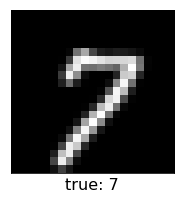

In [17]:
training_index = 0
view_digit(X_train[training_index], y_train[training_index])

In [18]:
print("There are {} pixels in each image.".format(len(X_train[0])))
print("There are {} examples in the training dataset.".format(len(X_train)))
print("There are {} examples in the validation dataset.".format(len(X_valid)))


There are 441 pixels in each image.
There are 4000 examples in the training dataset.
There are 1000 examples in the validation dataset.


A1) There are 441 pixels in each image.

A2) There are 4000 examples in the training dataset.

A3) There are 1000 examples in the validation dataset.

YOUR ANSWER HERE

In [25]:
class KNN:
    """
    Class to store data for regression problems 
    """
    # static class variable for Tie Breaking cases
    currentData = []
    
    def __init__(self, X_train, y_train, K=5, distance_weighted=False):
        """
        Creates a kNN instance

        :param X_train: Training data input in 2D ndarray 
        :param y_train: Training data output in 1D ndarray 
        :param K: The number of nearest points to consider in classification
        :param distance_weighted: Bool indicating whether to use distance weighting
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree        
        self.balltree = BallTree(X_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.x_train = X_train
        self.K = K 
        
       
        

        
        # Boolean flag indicating whether to do distance weighting 
        self.distance_weighted = distance_weighted
    
    def setK(self,k):
        self.K = k
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        hashtable = {} 
        


        # if using weighted KNN 
        if(neighbor_distances != None):
            for i in range(len(neighbor_indices)):
                if self.y_train[neighbor_indices[i]] in hashtable:
                    hashtable[self.y_train[neighbor_indices[i]]] += (1.0 * (1/neighbor_distances[i]))
                else:
                    hashtable[self.y_train[neighbor_indices[i]]] = (1.0 * (1/neighbor_distances[i]))
        else:
            # else for unweighted KNN
            for i in neighbor_indices:
                if self.y_train[i] in hashtable:
                    hashtable[self.y_train[i]] += 1
                else:
                    hashtable[self.y_train[i]] = 1

                
        
        #print(hashtable) #  < DEBUG >
        
        # Max value in hash table
        import operator
        predictionKey = max(hashtable.items(), key=operator.itemgetter(1))[0]
        
        
        # TIE MANAGEMENT
        ties = -1
        for key, value in hashtable.items():
            if(value == hashtable[predictionKey]):
                ties += 1; 
                # checks for ties, ties varaible should be 0 if there are no ties
                # it will be 1 or more is a tie is found
        
        if(ties >  0):        
            #print("< Need to break ties > :" + str(hashtable) + "\n") #  < DEBUG >
            # TIE BREAKER
            if(self.distance_weighted):
                TieBreaker = KNN(self.x_train,self.y_train,self.K -1,True)
            else:
                TieBreaker = KNN(self.x_train,self.y_train,self.K -1)
            predictionKey = TieBreaker.classify(KNN.currentData)
           
        return predictionKey
    
        
            
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        KNN.currentData = x
        #print("\nInput to predict " + str(x)) # < DEBUG >
        
        
        dist, idx = self.balltree.query([x],self.K) 
        
        #print("Nearst Neighbors indexs: " + str(idx[0]))  # < DEBUG >
        
        if(self.distance_weighted):
            out = self.majority(idx[0],dist[0])
        else:
            out = self.majority(idx[0])

        return out
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        #print("K is " + str(self.K))  # < DEBUG >

        lables = []
        count = 0
        for i in range(len(X)):
            #print("index: " + str(i))  # < DEBUG >
            lables.append(self.classify(X[i]))
            
        return lables


In [26]:
import warnings
warnings.filterwarnings('ignore')



In [27]:

obj = KNN(X_train,y_train,5)

lables = obj.predict(X_valid)

## Program produces warnings Please Ignore

In [28]:
incorrect =[]
for i in range(len(lables)):
    if(lables[i] != y_valid[i]):
        incorrect.append(i)
        
print("Incorrect: ",len(incorrect), " / ",len(lables))
#incorrect

Incorrect:  39  /  1000


Predicted: [9]
Actual: 8


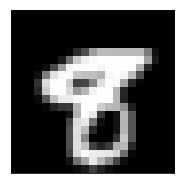

In [75]:
def errorDisplay(idx):
    view_digit(X_valid[idx])
    
    predicted = obj.predict([X_valid[idx]])
    print("Predicted: " + str(predicted))
    print("Actual: " + str(y_valid[idx]))

errorDisplay(6)

**Part B [10 points]**: Modify the class above to implement an Unweighted KNN classifier.  There are three methods that you need to complete: 

- `predict`: Given an $m \times p$ matrix of validation data with $m$ examples each with $p$ features, return a length-$m$ vector of predicted labels by calling the `classify` function on each example. 
- `classify`: Given a single query example with $p$ features, return its predicted class label as an integer using KNN by calling the `majority` function. 
- `majority`: Given an array of indices into the training set corresponding to the $K$ training examples that are nearest to the query point, return the majority label as an integer.  If there is a tie for the majority label using $K$ nearest neighbors, reduce $K$ by 1 and try again.  Continue reducing $K$ until there is a winning label. 

**Notes**: 
- Don't even think about implementing nearest-neighbor search or any distance metrics yourself.  Instead, go read the documentation for Scikit-Learn's [BallTree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html) object.  You will find that its implemented [query](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree.query) method can do most of the heavy lifting for you. 
- Do not use Scikit-Learn's KNeighborsClassifier in this problem.  We're implementing this ourselves. 
- You don't need to worry about the `distance_weighted` flag until **Part C**, but we recommend reading ahead a bit. It might be good to think about your implementation of **Part C** before implementing **Part B**. 
- When you think you're done, execute the following cell to run 4 unit tests based on the example starting on Slide 24 of the [KNN Lecture](https://chenhaot.com/courses/csci4622/slides/lesson05.pdf).  

In [76]:
%run -i tests/tests1.py "prob 2A"

test1NNclassify (__main__.TestUnweightedKNN) ... ok
test2NNclassify (__main__.TestUnweightedKNN) ... ok
test3NNclassify (__main__.TestUnweightedKNN) ... ok
test3NNpredict (__main__.TestUnweightedKNN) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.021s

OK


**Part C [5 points]**: Modify the `KNN` class to perform the distance-weighted KNN classification.
The so-called Distance-Weighted KNN classifier assigns weights to the the nearest-neighbor training examples proportional to the inverse-distance from the training example to the query point.  Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.  Mathematically we might describe the weighted-vote for a class $c$ as 

$$
\textrm{Weighted-Vote}(c) = \displaystyle\sum_{i \in {\cal N}_K} I(y_i = c) \times \dfrac{1}{\|{\bf x}_i - {\bf x}\|}
$$

A word of caution: it's certainly possible that a query point could be distance $0$ away from some training example.  If this happens your implementation should handle it gracefully and return the appropriate class label.   

When you think you're done, execute the following cell to run three final unit tests corresponding to the example on Slide 43 of the [KNN Lecture](https://chenhaot.com/courses/csci4622/slides/lesson05.pdf). Make sure that the changes you make in **Part C** do not affect the unit tests from **Part B**.   


In [77]:
%run -i tests/tests1.py "prob 2B"

test5NNclassify (__main__.TestWeightedKNN) ... ok
test3NNclassify (__main__.TestWeightedKNN) ... ok
test5NNpredict (__main__.TestWeightedKNN) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


**Part D [7 points]**: Use your `KNN` class to perform Unweighted KNN on the validation data with $K=3$ and do the following: 

- **[2 points]** Create a **confusion matrix** (feel free to use the Scikit-Learn [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function).  


In [78]:
knn = KNN(X_train, y_train, K=3, distance_weighted=True)
yhat_valid = knn.predict(X_valid)

Labels = [8,7,3,9]
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_valid, yhat_valid,Labels)

print(C)



[[233   0   9   8]
 [  1 244   1   4]
 [ 10   2 236   2]
 [  0   3   3 244]]


- **[2 points]** Based on your confusion matrix, which digits seem to get confused with other digits the most? 

From the Matrix I can see that **8** gets confused with **3** and vice versa a total of **19** times


- **[3 points]** Find one misclassified validation example and plot it with the `view_digit` function along with plots of its three nearest neighbors in the training set. 


Predicted: [3]
Actual: 8

X_valid[876] is an 8 that is classified as 3. 
Its  3 Nearest Neighbors are in indexes [2043, 585, 616] in training set


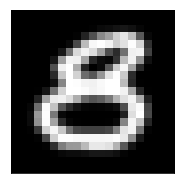

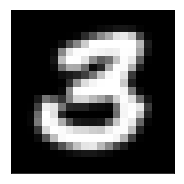

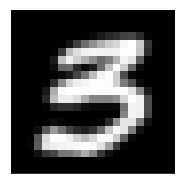

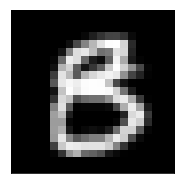

In [79]:
errorDisplay(876)

view_digit(X_train[2043])
view_digit(X_train[585])
view_digit(X_train[616])
print("\nX_valid[876] is an 8 that is classified as 3. \nIts  3 Nearest Neighbors are in indexes [2043, 585, 616] in training set")


**Part E [7 points]**: **[4 points]** Create a plot of the accuracy of both Unweighted and Distance-Weighted KNN on the validation set on the same set of axes for $K=1, 2, \ldots, 20$ (feel free to go out to $K=30$ if your implementation is efficient enough to allow it).


$$ Accuracy = \frac{Number of Correct Predictions}{Total Number of Predictions}$$

In [86]:
# function that prints the accuracy given its confusion matrix
def Accuracy(C):
    total = np.sum(C)
    correct = np.sum(np.diagonal(C))
    return float(correct)/total

def getData(K_Limit,Weighted=False):
    out = []
    Test = KNN(X_train,y_train,1,Weighted)
    for i in K_Limit:
        Test.setK(i)
        lab = Test.predict(X_valid)
        correct = 0
        for i in range(len(lab)):
            if(lab[i] == y_valid[i]):
                correct +=1
        
        out.append(correct/len(lab))

    return out

In [87]:
# NOTE TO GRADERS: my KNN isnt optimized so feel free to grab some coffee if you decide run this Code Cell
acc = []
wacc = []
allks = range(1,30)

acc = getData(allks)
wacc = getData(allks,True)

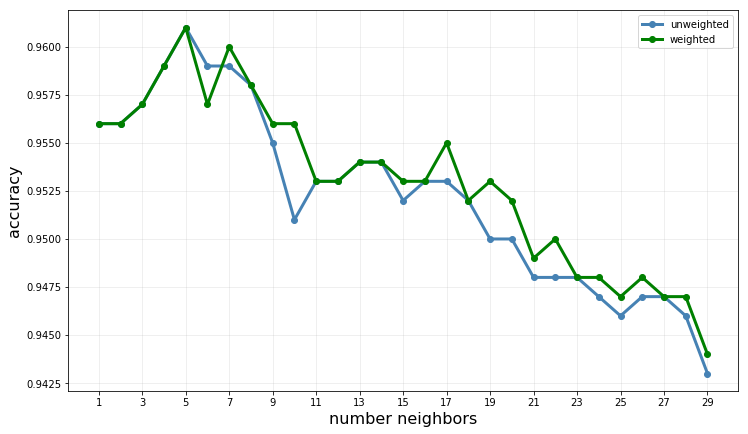

In [88]:
acc = np.array(acc)
wacc = np.array(wacc)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, wacc, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)

**[4 points]** Based on the plot, answer the following questions: 

- For general $K$, does Unweighted or Weighted KNN appear to perform better? 
- Which value of $K$ attains the best accuracy on the validation set? 


$$Answers$$
* As you can see from the graph: In most cases weighted (green line) is slightly higher on the graph therefore it preformes better then unweighted

* The best accuracy value was optained when K = 5 for both weighted and unweighted

### [30 points] Problem 3 - Polynomial Regression  and the Bias-Variance Trade-Off
***

In this problem you will use polynomial regression to explore the Bias-Variance Trade-Off. Assume that our data comes from a model of the form 

$$Y = f(X) + \epsilon ~~\textrm{ where }~~ \epsilon \sim N(0,\sigma^2)$$ 

For our experiments we'll use $f(x) = \sin(\pi x)$. The following functions can be used to generate data from this distribution:    

In [62]:
def get_f(x):
    """
    Returns sin(pi*x) for array of x values
    
    :@param x: ndarray of feature values
    """
    return np.sin(np.pi * x)

**Part A [6 points]**: **[3 points]** Generate a sample of size $n=20$ for $x$-values chosen from a uniform distribution between $0$ and $1$.

In [63]:
def get_y(x, sigma=1.0):
    """
    Returns y values based on the data generation process.
    Note the noise term.
    
    :@param x: ndarray of feature values
    """
    # YOUR CODE HERE
    f_X = get_f(x)  
    for i in range(len(f_X)):
        f_X[i] += np.random.normal(0,sigma)
    
    return f_X
    
def sample(n, sigma=1.0):
    """Return tuples of data (x, y) that come from 
    the data generation process."""
    x = np.random.uniform(0, 1, size=n)
    y = get_y(x, sigma=sigma)
    return x, y

**[3 points]**: Make a scatter plot of the data overlayed with the curve of the true function $f(x)=\sin(\pi x)$. 

(0, 1)

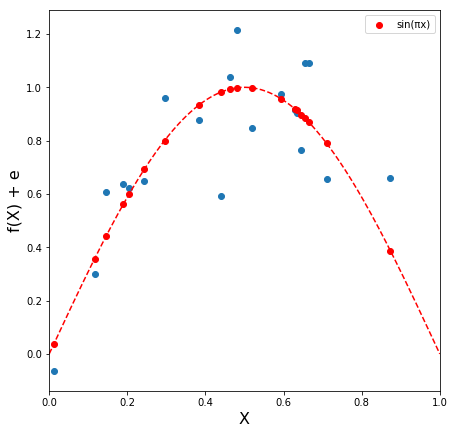

In [64]:
n = 20
x, y = sample(n, sigma=.15)
xplot = np.linspace(0, 1, 200)
fplot = get_f(xplot)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.scatter(x,y)
ax.scatter(x,np.sin(np.pi*x), color="red", label="sin(πx)", )
xx = np.linspace(0,1,200)
plt.plot(xx,np.sin(xx*np.pi),'r--')
ax.legend(loc="upper right")
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("f(X) + e", fontsize=16)
plt.xlim([0, 1])


**Part B [6 points]**: **[3 points]** Next we need to create a function that can fit a polynomial model to training data and make predictions for unseen data.  Complete the function `poly_predict` below to accomplish this.  Note that there are many ways to do this in Python.  Later this week we'll look into doing this with Scikit-Learn.  You're free to implement it using Scikit-Learn, but you might want to look into Numpy's polynomial fitting functions, [polyfit](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyfit.html) and [polyval](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.polyval.html).


In [65]:
def poly_predict(x_train, y_train, x_valid, deg):
    """
    Function to train polynomial regression model on training data
    and then return a vector of predictions on validation data
    
    :@param x_train: vector of training features
    :@param y_train: vector of training responses
    :@param x_valid: vector of validation features to make predictions with
    :@param deg: degree of the polynomial model 
    """
    
    Coefficient = np.polyfit(x_train,y_train,deg)
    y_valid = np.polyval(Coefficient, x_valid)
    return y_valid

**[3 points]**: Demonstrate that your function is working by using it to generate a plot that include the true function $f(x)$, a scatter plot of your training data, and the curve representing your fitted model. 

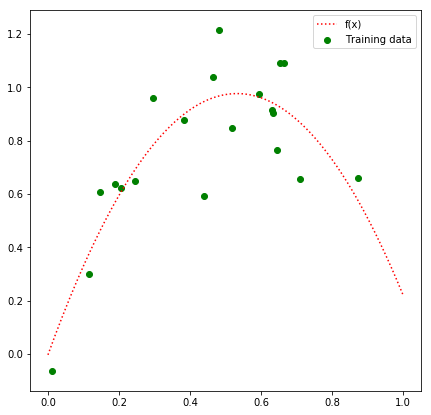

In [113]:
model_plot = poly_predict(x, y, xplot, 2)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.scatter(x,y,label="Training data",color="green")
ax.plot(xplot,model_plot, color= "red", label="f(x)",linestyle=":")
ax.legend(loc="upper right")


**Part C [12 points]**: Our goal now will be to make a plot of the decomposition of the expected validation MSE into it's constituent parts.  Recall that we showed in lecture that the expected test MSE can be written as 

$$
\textrm{E}\left[\left(y_0 - \hat{f}(x_0) \right)^2\right] = \left[~f(x_0) - \textrm{E}[~\hat{f}(x_0)~] \right]^2
+ \textrm{E}\left[ ~ \textrm{E}[~\hat{f}(x_0)]-\hat{f}(x_0)~\right]^2 + \textrm{Var}(\epsilon)
= \left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 + \textrm{Var}(~\hat{f}(x_0)~) + \textrm{Var}(\epsilon)
$$

where $x_0$ represents unseen validation data. We're going to run simulations to estimate $\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2$ and $\textrm{Var}(~\hat{f}(x_0)~)$ for different polynomial models and then plot them against estimates of the true validation MSE. The function `bias_variance_study` below will help you do this.  You just need to fill in a few key parts.  At the end of the day, you should have a plot that looks like this for certain choices of the simulation parameters.  

The $\textrm{Bias}^2$ term is given by 

$$
\left[\textrm{Bias}(~\hat{f}(x_0)\right]^2 = \left[~f(x_0) - \textrm{E}[~\hat{f}(x_0)~] \right]^2
$$

The first term inside the square is simply the true function $f$ evaluated on the validation data.  The second term inside the square, $\textrm{E}[~\hat{f}(x_0)~]$, is the expected value of all estimated models evaluated on the validation data.  We can estimate this by sampling many many training sets, fitting models, evaluating them on many validation sets, and then taking the average. Complete the `squared_bias` function below to do this computation.  

The next step is to estimate the $\textrm{Variance}$.  Let's unpack it 

$$
\textrm{E}\left[ ~ \hat{f}(x_0) - \textrm{E}[~\hat{f}(x_0)]~\right]^2
$$

Note that $\textrm{E}[~\hat{f}(x_0)]$ is the `mean_model` we got from the `squared_bias` function. The other term, $\hat{f}(x_0)$, is a model estimated on a random training set, and then evaluated on the validation set.  Since we're wrapping this whole thing in an expectation, we're going to sample many many training sets, estimate $\hat{f}(x_0)$, and then compute the mean squared deviation between these and the `mean_model`.  You will add code to the function below to accomplish this. 

We'll also estimate the validation MSE so we can compare this to the bias-variance decomposition, but this portion of the code is completed for you. 

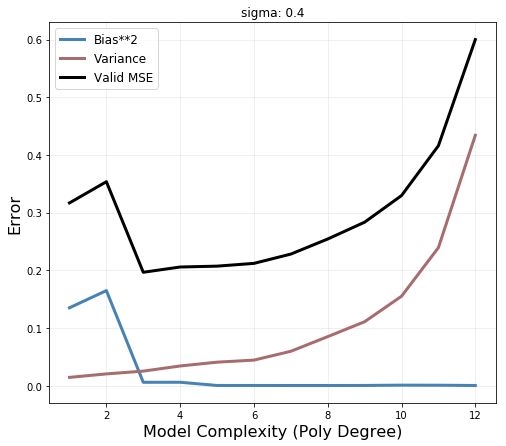

In [161]:
def bias_variance_study(num_data, num_sims, train_frac=0.8, sigma=0.4, max_deg=10, random_state=1234):
    '''
    Function to run simulations and estimate the squared-bias, variance, and 
    validation error of polynomial regression models. 
    
    :@param num_data: number of points in simulated data set 
    :@param num_sims: number of simulations to run 
    :@param train_frac: fraction of total data in training set
    :@param sigma: standard deviation of noise in data 
    :@param max_deg: largest degree polynomial to analyze
    :@param random_state: seed for random state, for reproducibility
    '''
    # Set random seed 
    np.random.seed(random_state)
    
    # array of polynomial degrees
    degrees = range(1, max_deg + 1)
    
    # train/valid split sizes 
    num_train = int(np.ceil(train_frac * num_data))
    num_valid = num_data - num_train
    
    # Generate grid of features and shuffle them 
    x_grid = np.linspace(-1, 1, num_data)
    np.random.shuffle(x_grid)
    
    # Spit into training and validation sets 
    x_train = x_grid[:num_train]
    x_valid = x_grid[num_train:]
    
    # Dictionaries for predictions and MSE measurements
    # Keys are polynomial degree. Each prediction is column 
    # of nValid x num_sims array. Each mse is entry in vector
    # of length num_sims 
    y_hat_valid = {deg: np.zeros((num_valid, num_sims)) for deg in degrees}
    mses_valid = {deg: np.zeros(num_sims) for deg in degrees}
    
    # Loop over num_sims simulated data sets
    for sim in range(num_sims):
        
        # Generate training and validation responses 
        y_train = get_y(x_train, sigma=sigma)
        y_valid = get_y(x_valid, sigma=sigma)
        
        # Loop over polynomial degree.  Use function from part B 
        # to fit to training set and predict on validation set.
        # Store predictions those predictions in y_hat_valid[deg]
        
        '''STUDENT CODE'''
        
        for i in degrees:
            y_hat_valid[i][:,sim] = poly_predict(x_train, y_train, x_valid, i)
            mses_valid[i][sim] = np.mean((y_valid - y_hat_valid[i][:,sim])**2 ) 
        '''END'''
    
    #print(y_hat_valid)
    # Loop over each polynomial degree and compute squared-bias, variance, 
    # and mean MSE on validation set.  
    bias_squared, variance, mse_valid = np.zeros(max_deg), np.zeros(max_deg), np.zeros(max_deg) 

    '''STUDENT CODE'''
    
    #print(y_valid)
    #print([y_valid[i] for i in range(len(y_valid))])
    
    #for key,value in y_hat_valid.items():
        #bias_squared[key-1] =  np.mean([(y_valid[i]) - [(np.sum(value[ix][i])) for ix in range(len(value)) ] for i in range(len(y_valid)) ])
            # TODO implement the functions for bias squared from above 
            #variance[key-1] = np.mean(np.var(value), axis=1)
            #mse_valid[key-1] = bias_squared[key-1] + variance[key-1]
    
    for ii, deg_val in enumerate(degrees):
        bias_squared[ii] = np.mean((get_f(x_valid) - y_hat_valid[deg_val].mean(axis=1))**2)
        variance[ii] = np.mean((y_hat_valid[deg_val] - y_hat_valid[deg_val].mean(axis=1).reshape(-1,1))**2)
        mse_valid[ii] = np.mean(mses_valid[deg_val])
  
    #print("bias squared: \n",bias_squared)
    
    '''END'''
        
    # Plot squared bias, variance, and validation MSE 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
    ax.plot(degrees, bias_squared, color="steelblue", lw=3, label="Bias**2")
    ax.plot(degrees, variance, color="#a76c6e", lw=3, label="Variance")
    ax.plot(degrees, mse_valid, color="black", lw=3, label="Valid MSE")
    ax.grid(alpha=0.25)
    title = "sigma: " + str(sigma)
    ax.set_title(title)
    ax.set_xlabel("Model Complexity (Poly Degree)", fontsize=16)
    ax.set_ylabel("Error", fontsize=16)
    ax.legend(loc="best", fontsize=12)
    
    # Return arrays of squared-Bias, variance, and MSE 
    return bias_squared, variance, mse_valid
    
        
bias_squared, variance, mse_valid = bias_variance_study(30, 500, train_frac=0.80,
                                                        sigma=0.4, max_deg=12,
                                                        random_state=1241)

**Part D [6 points]**: When everything is working, increase the size of the simulated data sets and the number of simulation runs and compare the difference between the validation MSE and the sum of the squared-Bias the Variance for each polynomial degree.  Try this for several values of the standard deviation of the model noise.  What do you notice?  How can you explain this result using the notions of Bias-Variance and Reducible and Irreducible error discussed in class?   

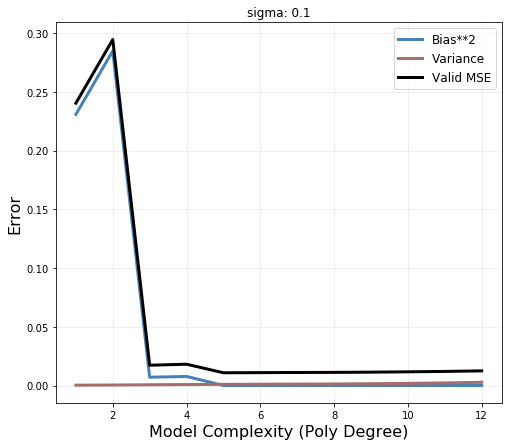

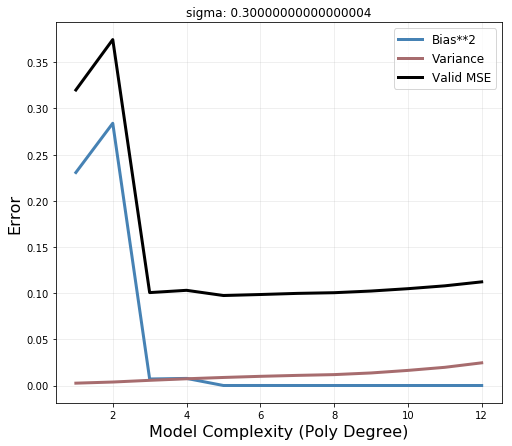

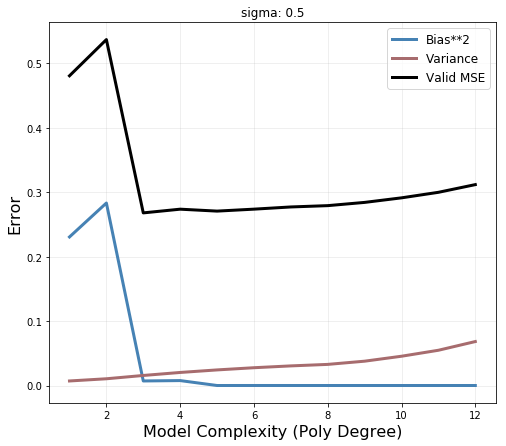

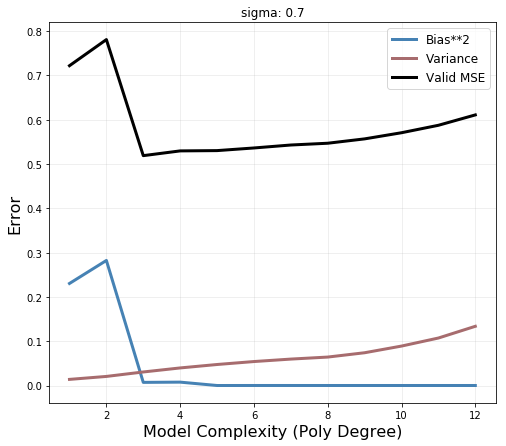

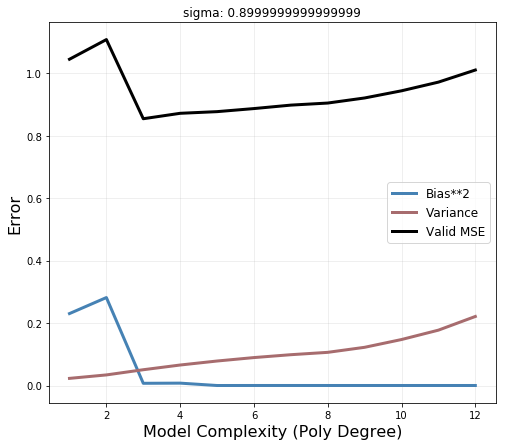

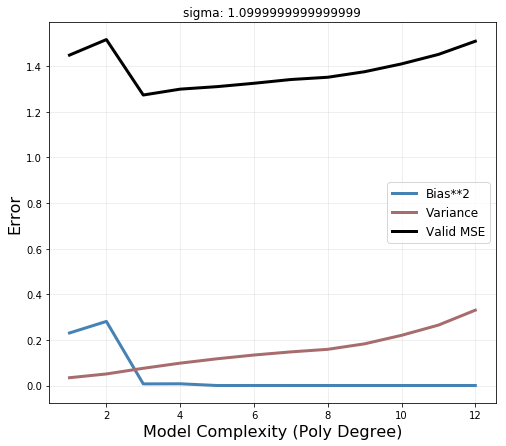

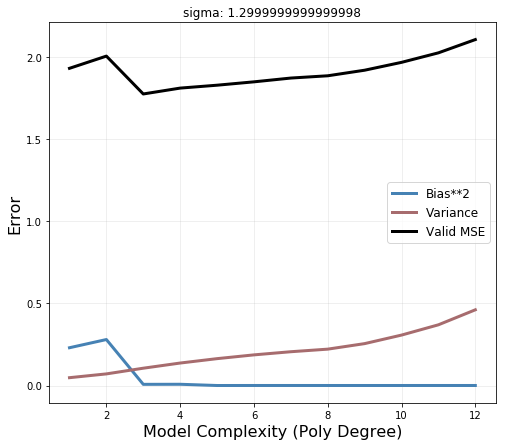

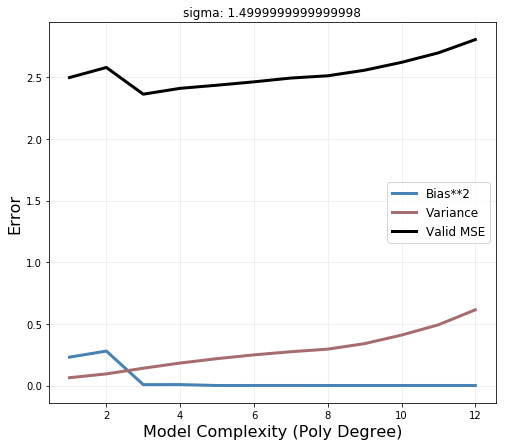

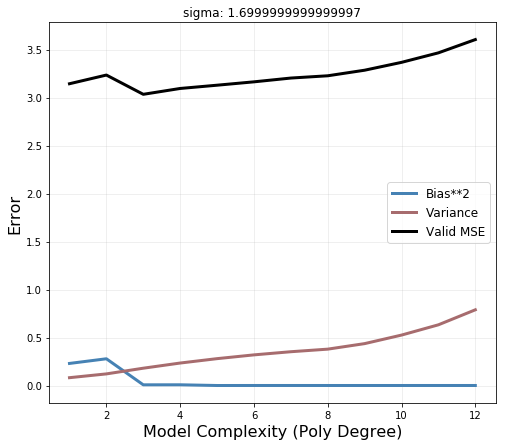

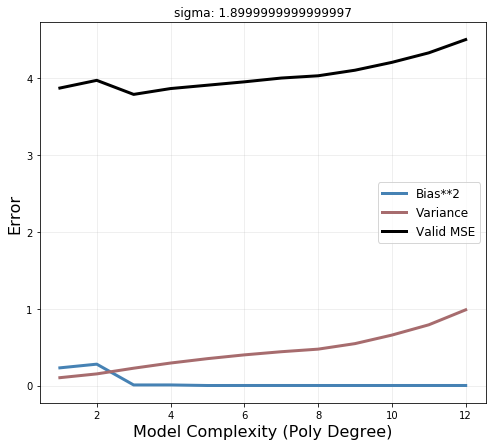

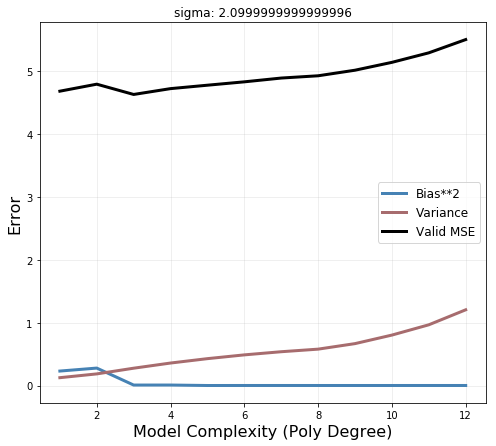

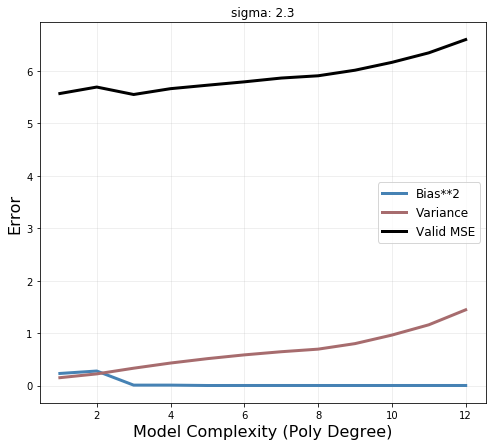

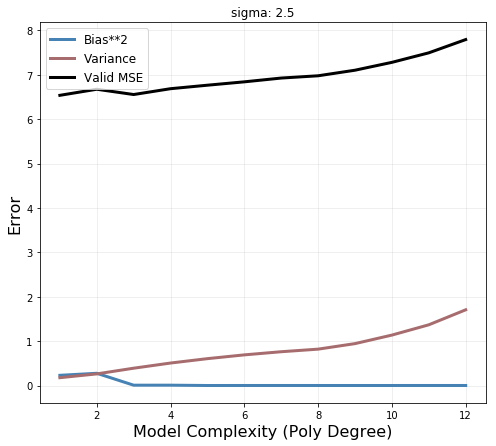

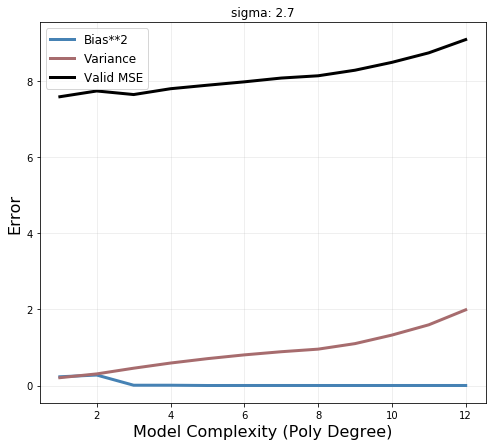

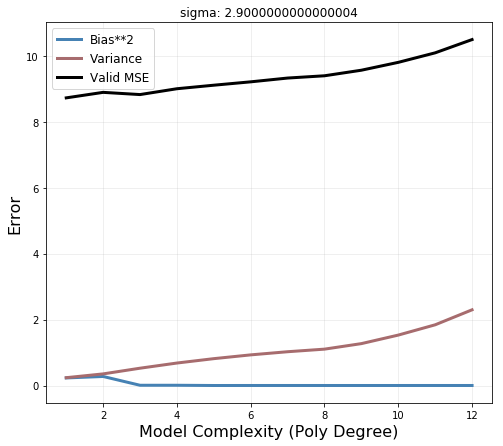

In [166]:
#
def frange(x, y, jump):
    while(x < y):
        yield x
        x += jump
    
for i in frange(.1, 3, 0.2):
    bias_squared, variance, mse_valid = bias_variance_study(100, 600, train_frac=0.80,
                                                        sigma=i, max_deg=12,
                                                        random_state=1241)
    

Increaced standard defviation seems to make the curve less boxy and more like a polynomal, with high values of sigma (ie sigma = 4) both bias and variance seem to start with the same error at the first few degrees. low values of sigma seem to have high $Bias^2$

<br>
From the graphs we can see that the the **$Bias^2$** decreases as the degrees increase, thus **$Bias^2$** is the  Reducible error and the Irreducible error is the **Variance** since the variance only increases as the degrees are increased

### [5 points] Problem 4: Syllabus quiz
***

Please read the [syllabus](https://github.com/BoulderDS/CSCI-4622-Machine-Learning-18fa/blob/master/info/schedule.md) carefullly and finish the [Syllabus quiz](https://goo.gl/forms/pRv3hYrzsUV33OYL2). You do not need to answer anything here. The Markdown cell is only for grading convenience.

YOUR ANSWER HERE

### Optional survey.
***

We are always interested in your feedback. At the end of each homework, there is a simple anonymous feedback [survey](https://goo.gl/forms/4d9qMlQGYbqq1uNX2) to solicit your feedback for how to improve the course.